In this project, you will create a classification model for dogs breeds, which should work on any photo and provide a classification outcome for it, assign each photo with a breed label.

The training data is in the folder Breeds_classification/Dataset. You can find your own samples (random images of dogs or other animals) for testing the model outside of the provided data.

The data loading and initial preprocessing is provided below. You are free to do further preprocessing if you think it might be useful.
- Be careful if you are running pytorch on a machine with a gpu or a cpu, you might need to do some adjustments for that.

The main requirement of the project is to achieve average accuracy of 90% or higher. More detailed instructions are provided below.


In [33]:
!pip install lightning

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 10.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 806.1/806.1 kB 20.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 776.9/776.9 kB 24.8 MB/s eta 0:00:00


In [34]:
#visualization
import matplotlib.pyplot as plt
#data manipulations
import numpy as np
import pandas as pd
#pytorch
import torchvision
import torchvision.models as models
import torch
import torch.optim as optim
import torch.nn as nn
import torch.nn.functional as f
import pytorch_lightning as pl
from PIL import Image
#dealing with images from Internet
import requests
from io import BytesIO
# time tracking
from timeit import default_timer as timer

from google.colab import drive

In [35]:
# mount the Google Drive files
drive.mount("/content/gdrive")

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


Load the dataset after some standard transforms. Do not forget to adjust the path to the data.

In [27]:

# transforms for images
transforms = torchvision.transforms.Compose([
    torchvision.transforms.Resize((224, 224)),
    torchvision.transforms.CenterCrop(224),
    torchvision.transforms.ToTensor(),
    torchvision.transforms.RandomHorizontalFlip(p = 0.5)
])

drive.mount("/content/gdrive")
base_path = "gdrive/MyDrive/Dataset_DOGS"

# datasets
trainset = torchvision.datasets.ImageFolder(base_path + "/test", transform = transforms)
validset = torchvision.datasets.ImageFolder(base_path + "/valid", transform = transforms)
testset = torchvision.datasets.ImageFolder(base_path + "/test", transform = transforms)

#batches
batch_size = 128

# loaders for data

trainloader = torch.utils.data.DataLoader(trainset , batch_size=batch_size , shuffle = True)
validloader = torch.utils.data.DataLoader(validset , batch_size=batch_size , shuffle = True)
testloader = torch.utils.data.DataLoader(testset  , batch_size=batch_size)




Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


Visualize some images.

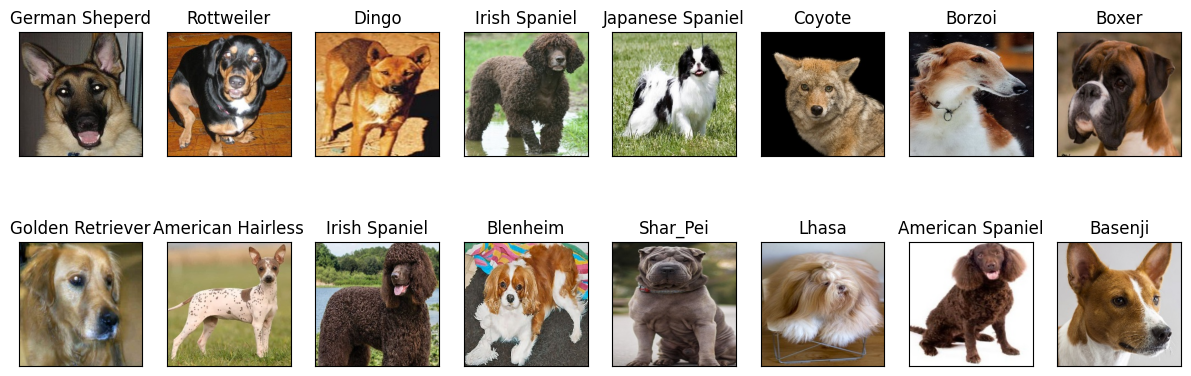

In [28]:
images, labels = next(iter(trainloader))
images, labels = images.numpy() , labels.numpy()


fig = plt.figure(figsize = (15,5))

for i in range(int(batch_size/8)):
    ax = fig.add_subplot(2 , int(batch_size/16) , i + 1 , xticks = [] , yticks = [])
    ax.imshow(np.transpose(images[i] , (1,2,0)) , cmap = 'gray')
    ax.set_title(trainset.classes[labels[i]])

In [29]:
# Single batch
print("number of train batches : ", len(trainloader))
print("number of validation batches : ", len(validloader))
print("Size of test batches : ", len(testloader))

number of train batches :  6
number of validation batches :  6
Size of test batches :  6


In [30]:
print("Classes : ", trainset.classes)

Classes :  ['Afghan', 'African Wild Dog', 'Airedale', 'American Hairless', 'American Spaniel', 'Basenji', 'Basset', 'Beagle', 'Bearded Collie', 'Bermaise', 'Bichon Frise', 'Blenheim', 'Bloodhound', 'Bluetick', 'Border Collie', 'Borzoi', 'Boston Terrier', 'Boxer', 'Bull Mastiff', 'Bull Terrier', 'Bulldog', 'Cairn', 'Chihuahua', 'Chinese Crested', 'Chow', 'Clumber', 'Cockapoo', 'Cocker', 'Collie', 'Corgi', 'Coyote', 'Dalmation', 'Dhole', 'Dingo', 'Doberman', 'Elk Hound', 'French Bulldog', 'German Sheperd', 'Golden Retriever', 'Great Dane', 'Great Perenees', 'Greyhound', 'Groenendael', 'Irish Spaniel', 'Irish Wolfhound', 'Japanese Spaniel', 'Komondor', 'Labradoodle', 'Labrador', 'Lhasa', 'Malinois', 'Maltese', 'Mex Hairless', 'Newfoundland', 'Pekinese', 'Pit Bull', 'Pomeranian', 'Poodle', 'Pug', 'Rhodesian', 'Rottweiler', 'Saint Bernard', 'Schnauzer', 'Scotch Terrier', 'Shar_Pei', 'Shiba Inu', 'Shih-Tzu', 'Siberian Husky', 'Vizsla', 'Yorkie']


From here on, you are free to run your classification model.

You can train your own model, and/or use pretrained models.

Can you achieve accuracy > 90% on all classes?

The more detailed report you provide on the performance of the models, the more you can improve on your classification. Think of different ways how to visualize and analyze the performance and the accuracy of your model. What is influencing them? How do you measure the performance of your model? Which hyperparameters are critical to improve the performance? How do the performance and accuracy change with the number of training epochs?
Can you apply your model to random images from the internet?

You can try it on several images from different classes. What happens if you provide an image of other animal?

(written by author)
My approach was to judge the model according to:
- accuracy
- precision
- recall and the
- F1 score

Furthermore a pretrained ResNet50 Model is used from PyTorch.In addition PyTorch Lightning was used for more readable code: https://lightning.ai/pytorch-lightning library,

In [31]:
# here defined what the device is => if GPU available us GPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [52]:
class DogBreedClassification(pl.LightningModule):
  def __init__(self, num_of_classes) -> None:
     super().__init__()
     self.resnet = models.resnet50(pretrained=True)
     # Last layer configuration - Output size accroding to num_of_classes (here number of dog breeds)
     self.resnet.fc = nn.Linear(self.resnet.fc.in_features, num_of_classes)

  def forward(self, x):
    return self.resnet(x)

  def configure_optimizers(self):
    # used SGD with momentum because as learned in Lab05_CNN/P05a_Inception_ResNet_DenseNet.ipynb
    # => Adam does work worse then AGD with momentum when using ResNet
    optimizer = optim.SGD(self.parameters(), lr=0.001, momentum=0.9)
    return optimizer

  def training_step(self, train_batch, batch_index):
    inputs, labels = train_batch
    outputs = self(inputs)
    loss = nn.CrossEntropyLoss()(outputs, labels)
    self.log("train_loss", loss)
    return loss

  def validation_step(self, validation_batch, batch_index):
    inputs, labels = validation_batch
    outputs = self(inputs)
    loss = nn.CrossEntropyLoss()(outputs, labels)
    self.log("validation_loss", loss)

In [53]:
num_of_classes = len(trainset.classes)
num_of_classes

70

In [54]:
model = DogBreedClassification(num_of_classes).to(device)
trainer = pl.Trainer(max_epochs=50)
trainer.fit(model, trainloader, validloader)

INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
  | Name   | Type   | Params
----------------------------------
0 | resnet | ResNet | 23.7 M
----------------------------------
23.7 M    Trainable params
0         Non-trainable params
23.7 M    Total params
94.606    Total estimated model params size (MB)


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/pytorch_lightning/trainer/connectors/data_connector.py:441: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=1` in the `DataLoader` to improve performance.
/usr/local/lib/python3.10/dist-packages/pytorch_lightning/loops/fit_loop.py:293: The number of training batches (6) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=50` reached.
